In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Do this once in the kernel.
import sys
sys.path.append('src')
sys.path.append('tests')

# Set to automatically reload.
# Turn off for now.
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plan of experiment  
- Verify that the wordlist tools work as advertised.  
- Upgrade shell Markov class to include MarkovCharLM class and perform stub funcions.  
- Demonstrate plotting separate from Markov module.
- Integrate command line access.  
- Upgrade features as needed.  

In [37]:
# Compile code for MarkovCharLM...
import py_compile
#py_compile.compile('src/utility_functions.py')
#py_compile.compile('src/markov_char_lm.py')
#py_compile.compile('src/markov_model_analysis.py')

py_compile.compile('src/mobor/__init__.py')
py_compile.compile('src/mobor/cli.py')
py_compile.compile('src/mobor/data.py')
py_compile.compile('src/mobor/markov.py')
py_compile.compile('src/mobor/plot.py')

py_compile.compile('src/mobor/commands/__init__.py')
py_compile.compile('src/mobor/commands/plot_entropy.py')


'src/mobor/__pycache__/__init__.cpython-38.pyc'

'src/mobor/__pycache__/cli.cpython-38.pyc'

'src/mobor/__pycache__/data.cpython-38.pyc'

'src/mobor/__pycache__/markov.cpython-38.pyc'

'src/mobor/__pycache__/plot.cpython-38.pyc'

'src/mobor/commands/__pycache__/__init__.cpython-38.pyc'

'src/mobor/commands/__pycache__/plot_entropy.cpython-38.pyc'

In [3]:
#from utility_functions import *
#from markov_char_lm import MarkovCharLM
#from markov_model_analysis import analyze_language_word_distributions
#from markov_model_analysis import analyze_language_word_distributions_native_basis
#from markov_model_analysis import language_word_discrimination_dual_basis
#from markov_model_analysis import language_word_discrimination_native_basis
#from markov_model_analysis import language_word_discrimination_dual_basis
#from markov_model_analysis import language_word_discrimination_native_basis
#from markov_model_analysis import k_fold_language_word_discrimination_native_basis
#from markov_model_analysis import k_fold_language_word_discrimination_dual_basis
#from markov_model_analysis import k_fold_entropy_for_language


# Implement wordlist functions.  

In [5]:
from mobor.cli import main
from mobor.data import Wordlist
from mobor.markov import Markov
from mobor.plot import plot_word_distributions
from mobor.commands import plot_entropy
from tabulate import tabulate
import math


In [6]:
wl = Wordlist.from_lexibank('wold', 
                            fields=['borrowed'],
                            #fields=['loan', 'borrowed'],
                            fieldfunctions={"borrowed": lambda x: (int(x[0])*-1+5)/4})

2020-04-29 09:11:08,709 [INFO] loaded wordlist 1814 concepts and 41 languages


In [7]:
wl.columns

['concept',
 'concepticon',
 'doculect',
 'glottocode',
 'value',
 'form',
 'tokens',
 'borrowed']

In [8]:
# Dropped loan.
#table = wl.get_language('English', [ 'concept', 'form', 'formchars', 'tokens', 'sca', 'borrowed', 'loan'],
#                       dtypes=[str, str, str, str, str, lambda x: '{0:.2f}'.format(x), str])


# Repeat  execution of cell will overwrite formchars and sca, with warning from Wordlist.
# Loan can be calculated based on borrowed. Better local control to determine what is loan or native.
table = wl.get_language('English', [ 'concept', 'form', 'formchars', 'tokens', 'sca', 'borrowed'],
                       dtypes=[str, str, str, str, str, lambda x: '{0:.2f}'.format(x)])

print(tabulate(table[:20], headers=['id', 'concept', 'form', 'formchars', 'tokens', 'sca', 'borrowed'], 
               showindex=True, tablefmt='pipe'))

|    |   id | concept                | form      | formchars         | tokens          | sca             |   borrowed |
|---:|-----:|:-----------------------|:----------|:------------------|:----------------|:----------------|-----------:|
|  0 |   14 | the world              | world     | w o r l d         | w ɜː l d        | W E L T         |       0    |
|  1 |   63 | the land               | land      | l a n d           | l æ n d         | L E N T         |       0    |
|  2 |  112 | the soil               | soil      | s o i l           | s ɔɪ l          | S U L           |       1    |
|  3 |  158 | the dust               | dust      | d u s t           | d ʌ s t         | T E S T         |       0    |
|  4 |  213 | the mud                | mud       | m u d             | m ʌ d           | M E T           |       0.5  |
|  5 |  265 | the sand               | sand      | s a n d           | s æ n d         | S E N T         |       0    |
|  6 |  320 | the mountain or hill   | m

# Now we add our Markov module.  

In [9]:
mk = Markov(
        wl, 
        'English', 
        ['concept', 'form', 'formchars', 'tokens', 'sca', 'borrowed'],
        dtypes = [str, str, str, str, str, float]
        )
mk.add_sequences(
        [row['formchars'] for row in mk.now['dicts']])
        #[row['tokens'] for row in mk.now['dicts']])

mk.train(normalize='kneserney', smoothing=0.5)
e = mk.entropies(base=math.e)

Column <sca> already exists, do you want to override? [y/N] 
Column <formchars> already exists, do you want to override? [y/N] 


In [10]:
import statistics
statistics.mean(e), statistics.stdev(e)
mk.entropy('p r e c i p i c e', base=math.e)
mk.perplexity('p r e c i p i c e')

(1.9902002011346245, 0.290948012422926)

2.427853112521614

11.334521996830762

In [11]:
# Try out the separate native and loan distributions.
borrowed, unborrowed = [], []
for row in mk.now['dicts']:
    if row['borrowed']>=0.5:
        borrowed += [mk.entropy(row['formchars'], base=math.e)]
    else:
        unborrowed += [mk.entropy(row['formchars'], base=math.e)]


In [12]:
borrowed[:10], unborrowed[:10]
statistics.mean(borrowed), statistics.mean(unborrowed)

([2.0454917751852766,
  2.196889631800196,
  1.9486609799511732,
  2.427853112521614,
  1.715207590878187,
  2.4741154508126817,
  1.7793358248411277,
  1.7669675593666816,
  1.8048695572510849,
  2.8970546746961316],
 [2.143393640428475,
  1.585473699520013,
  2.347456025892021,
  1.714624447020079,
  1.8340975400578026,
  1.982194227263887,
  2.3953584939661874,
  1.9393344993437245,
  1.5876087048980039,
  2.6863305157365884])

(2.0408674969805616, 1.9528816773901372)

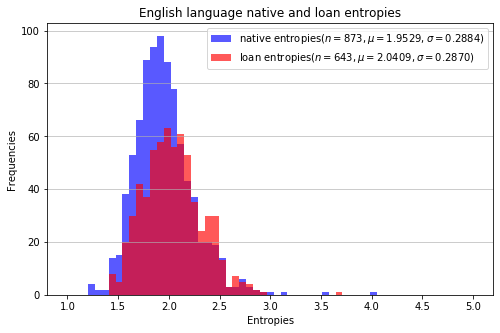

In [36]:
plot_word_distributions(unborrowed, borrowed, filename='test.pdf', 
            title="English language native and loan entropies", 
            graphlimit=max([max(borrowed), max(unborrowed)])+1)

In [39]:
%run "tests/test_data.py"

2020-04-29 10:16:28,784 [INFO] loaded wordlist 1814 concepts and 41 languages


|   id | concept                | form      | formchars         | tokens          | sca             |   borrowed |
|-----:|:-----------------------|:----------|:------------------|:----------------|:----------------|-----------:|
|   14 | the world              | world     | w o r l d         | w ɜː l d        | W E L T         |       0    |
|   63 | the land               | land      | l a n d           | l æ n d         | L E N T         |       0    |
|  112 | the soil               | soil      | s o i l           | s ɔɪ l          | S U L           |       1    |
|  158 | the dust               | dust      | d u s t           | d ʌ s t         | T E S T         |       0    |
|  213 | the mud                | mud       | m u d             | m ʌ d           | M E T           |       0.5  |
|  265 | the sand               | sand      | s a n d           | s æ n d         | S E N T         |       0    |
|  320 | the mountain or hill   | mountain  | m o u n t a i n   | m aʊ n t ɪ n  

2020-04-29 10:16:02,582 [INFO] loaded wordlist 1814 concepts and 41 languages


loaded markov
emitted graph to test.pdf


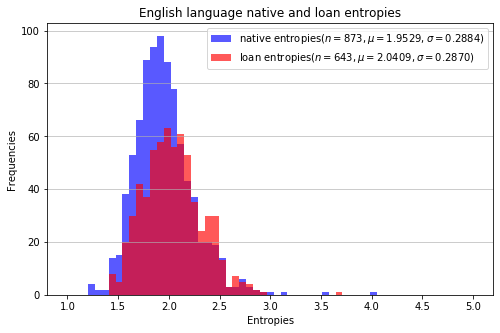

In [38]:
%run "tests/test_markov.py"